In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from zipfile import ZipFile
import skimage.io
from PIL import Image
import seaborn as sns
from sklearn.manifold import TSNE

from mnist_generator import get_mnist_loaders
from mnistm_generator import get_mnistm_loaders
from DANN import *
from DA import DenoisingAutoencoder
from test import *
from train import *
from visualize import *
from util import *

# make sure using CPU

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda', index=0)

# mnist dataset

In [4]:
mnist_train_loader,mnist_eval_loader, mnist_test_loader = get_mnist_loaders(batch_size=128)

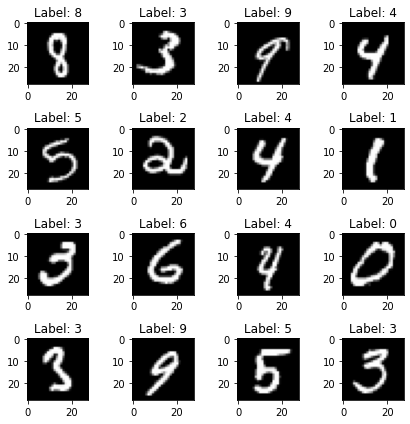

In [5]:

visualize_mnist(mnist_train_loader,4)

# mnistm dataset

In [6]:

mnistm_train_loader, mnistm_eval_loader,mnistm_test_loader = get_mnistm_loaders(batch_size=128)

C:\Users\15197\Desktop\cs9542_final_project\mnistm_generator.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  background = np.random.choice(backgrounds)


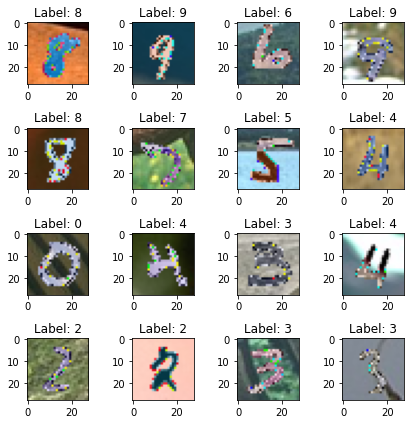

In [7]:
visualize_mnistm(mnistm_train_loader,4)

# visualization of representation

In [ ]:
features, labels = generate_domain_datas(mnist_train_loader, mnistm_train_loader)


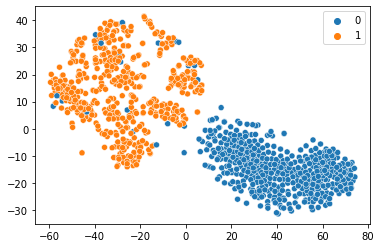

In [117]:

visualize_domain(features, labels, size=1000)

# build DANN model

In [8]:
source_accs, target_accs, domain_accs, extractor, classifier, discriminator = DANNTrain(
      mnist_train_loader,
      mnistm_train_loader,
      mnist_eval_loader,
      mnistm_eval_loader,
      epochs=30)

1/30: source_acc: 0.5271,target_acc: 0.2705166666666667, domain_acc: 0.927275


KeyboardInterrupt: 

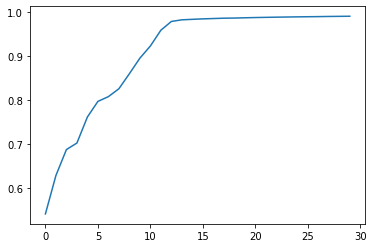

In [12]:
plt.plot(source_accs)

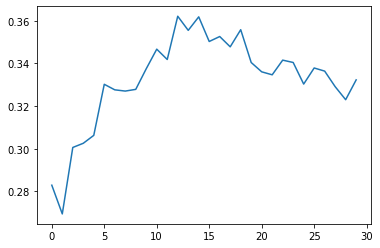

In [13]:
plt.plot(target_accs)

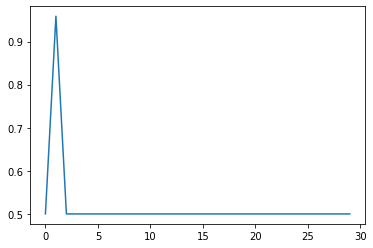

In [14]:
plt.plot(domain_accs)

# test on test set

In [15]:
DANNAccuracy(extractor, classifier, discriminator, mnist_test_loader, mnistm_test_loader)

(0.9901, 0.3302, 0.5)

# visualize the features after extractor

In [18]:
from util import generate_domain_datas_from_extractor
features, labels = generate_domain_datas_from_extractor(extractor, mnist_train_loader,mnistm_train_loader)

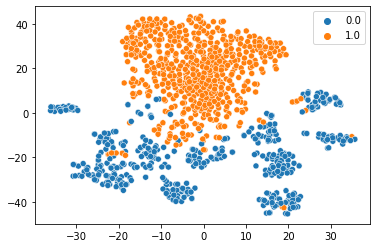

In [19]:
visualize_domain_tSNE(features, labels,size=1000)

# Denoising Autoencoders

In [8]:
loss_arr, autoencoder = DATrain(mnist_train_loader, mnistm_train_loader, mnist_eval_loader, mnistm_eval_loader,1000,100)

1/100: avg_loss:0.11483067274093628
2/100: avg_loss:0.09181162714958191
3/100: avg_loss:0.07582124322652817
4/100: avg_loss:0.06512131541967392
5/100: avg_loss:0.05722137168049812
6/100: avg_loss:0.05117691308259964
7/100: avg_loss:0.046461429446935654
8/100: avg_loss:0.042651329189538956
9/100: avg_loss:0.03974293917417526
10/100: avg_loss:0.03742653876543045
11/100: avg_loss:0.03554382547736168
12/100: avg_loss:0.0339069627225399
13/100: avg_loss:0.03245691955089569
14/100: avg_loss:0.03132209926843643
15/100: avg_loss:0.03028463013470173
16/100: avg_loss:0.02942045032978058
17/100: avg_loss:0.028599031269550323
18/100: avg_loss:0.027897696942090988
19/100: avg_loss:0.02726096659898758
20/100: avg_loss:0.02674141526222229
21/100: avg_loss:0.026187391951680183
22/100: avg_loss:0.025733469054102898
23/100: avg_loss:0.025307737290859222
24/100: avg_loss:0.024853214621543884
25/100: avg_loss:0.024516357108950615
26/100: avg_loss:0.024068474769592285
27/100: avg_loss:0.023727785795927048


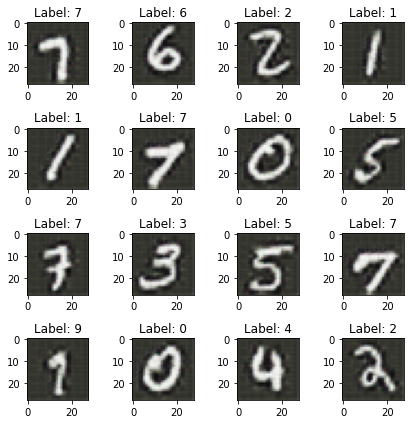

In [9]:
visualize_mnist_from_DA(autoencoder,mnist_train_loader,4)

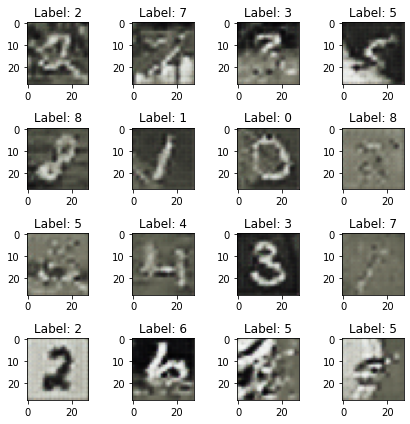

In [10]:
visualize_mnistm_from_DA(autoencoder,mnistm_train_loader,4)

In [12]:
save_DA(autoencoder,"./models/da_v1_100.pt")

In [8]:
autoencoder = DenoisingAutoencoder(100)
autoencoder = load_DA("./models/da_v1_100.pt")

# DANN with autoencoder

In [9]:
def DANNTrain_with_Autoencoder(autoencoder, mnist_train, mnistm_train, mnist_eval, mnistm_eval, epochs):
    extractor = LinearExtractor(16*7*7).to(device)
    classifier = Classifier(258).to(device)
    discriminator = Discriminator(258).to(device)
    for p in extractor.parameters():
        p.requires_grad = True
    for p in classifier.parameters():
        p.requires_grad = True
    for p in discriminator.parameters():
        p.requires_grad = True

    class_lossf= nn.NLLLoss().to(device)
    domain_lossf= nn.NLLLoss().to(device)
    optimizer = optim.SGD(
        list(extractor.parameters())+
        list(classifier.parameters())+
        list(discriminator.parameters()),lr=0.001,momentum=0.9)
    domain_accs =[]
    source_accs = []
    target_accs = []
    for epoch in range(epochs):
        start_steps = epoch * len(mnist_train)
        total_steps = epochs* len(mnistm_train)
        for batch_idx, (source, target) in enumerate(zip(mnist_train, mnistm_train)):
            source_image, source_label = source
            target_image, target_label = target

            p = float(batch_idx + start_steps)/ total_steps
            alpha = 2. / (1.+np.exp(-10*p))-1 

            # the source is 1 * 28 * 28, we have to preprocess it
            source_image = torch.cat((source_image, source_image, source_image),1)
            source_image, source_label = source_image.to(device), source_label.to(device)
            target_image, target_label = target_image.to(device), target_label.to(device)
            total_image = torch.cat((source_image, target_image), 0)
            domain_label = torch.cat((torch.zeros(source_label.size()[0]).type(torch.LongTensor),
                                    torch.ones(target_label.size()[0]).type(torch.LongTensor)),0).to(device)

            # update learning rate
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.001/(1.+10*p)**0.75

            # clear the grad
            optimizer.zero_grad()
            
            total_image = autoencoder.encoder(total_image)
            source_image = autoencoder.encoder(source_image)
            total_feature = extractor(total_image)
            source_feature = extractor(source_image)

            # classification loss
            yp = classifier(source_feature)
            class_loss = class_lossf(yp,source_label)

            # domain discriminate loss
            domain_yp = discriminator(total_feature,alpha)
            domain_loss = domain_lossf(domain_yp,domain_label)

            total_loss = class_loss+domain_loss
            total_loss.backward()
            optimizer.step()

        with torch.no_grad():
            source_acc, target_acc, domain_acc = DANNAccuracy_with_DA(autoencoder,extractor, classifier, discriminator, mnist_eval, mnistm_eval)
            domain_accs.append(domain_acc)
            source_accs.append(source_acc)
            target_accs.append(target_acc)
            print(f'{epoch+1}/{epochs}: source_acc: {source_acc},target_acc: {target_acc}, domain_acc: {domain_acc}')
    return source_accs, target_accs, domain_accs, extractor, classifier, discriminator

In [10]:
source_accs, target_accs, domain_accs, extractor, classifier, discriminator=DANNTrain_with_Autoencoder(autoencoder, 
                                                                                                       mnist_train_loader, 
                                                                                                       mnistm_train_loader, 
                                                                                                       mnist_eval_loader, 
                                                                                                       mnistm_eval_loader, 
                                                                                                       30)

1/30: source_acc: 0.47713333333333335,target_acc: 0.20491666666666666, domain_acc: 0.89025
2/30: source_acc: 0.54765,target_acc: 0.2610166666666667, domain_acc: 0.7048416666666667
3/30: source_acc: 0.6014333333333334,target_acc: 0.33368333333333333, domain_acc: 0.6489416666666666
4/30: source_acc: 0.63075,target_acc: 0.34486666666666665, domain_acc: 0.5856
5/30: source_acc: 0.6653333333333333,target_acc: 0.3542166666666667, domain_acc: 0.5142583333333334
6/30: source_acc: 0.6864333333333333,target_acc: 0.36441666666666667, domain_acc: 0.5
7/30: source_acc: 0.7028166666666666,target_acc: 0.3666333333333333, domain_acc: 0.5
8/30: source_acc: 0.7371666666666666,target_acc: 0.3685833333333333, domain_acc: 0.5
9/30: source_acc: 0.7672333333333333,target_acc: 0.3848666666666667, domain_acc: 0.5
10/30: source_acc: 0.7801166666666667,target_acc: 0.3935666666666667, domain_acc: 0.5
11/30: source_acc: 0.7837833333333334,target_acc: 0.40113333333333334, domain_acc: 0.5
12/30: source_acc: 0.786516

In [18]:
def save_DANN_with_DA(extractor, classifier, discriminator):
    torch.save(extractor.state_dict(),"./models/extractor_da.pt")
    torch.save(classifier.state_dict(),"./models/classifier_da.pt")
    torch.save(discriminator.state_dict(),"./models/discriminator_da.pt")
save_DANN_with_DA(extractor, classifier,discriminator)

In [11]:
DANNAccuracy_with_DA(autoencoder,extractor, classifier, discriminator, mnist_test_loader, mnistm_test_loader)

(0.9629, 0.4451, 0.5)

In [12]:
def generate_domain_datas_from_extractor_with_DA(autoencoder,extractor, mnist_gen,mnistm_gen):
    with torch.no_grad():
        total_x = torch.tensor([])
        total_y = torch.tensor([])
        for batch_idx, (source, target) in enumerate(zip(mnist_gen, mnistm_gen)):
            source_image, source_label = source
            target_image, target_label = target

            # the source is 1 * 28 * 28, we have to preprocess it
            source_image = torch.cat((source_image, source_image, source_image),1)
            total_image = torch.cat((source_image, target_image), 0)
            domain_label = torch.cat((torch.zeros(source_label.size()[0]).type(torch.LongTensor),
                                        torch.ones(target_label.size()[0]).type(torch.LongTensor)),0)
            total_image = autoencoder.encoder(total_image.to(device))
            temp = extractor(total_image).cpu()
            total_x = torch.cat((total_x,temp),0)
            total_y = torch.cat((total_y,domain_label),0)
    return total_x, total_y

In [13]:
features, labels = generate_domain_datas_from_extractor_with_DA(autoencoder,extractor, mnist_train_loader,mnistm_train_loader)

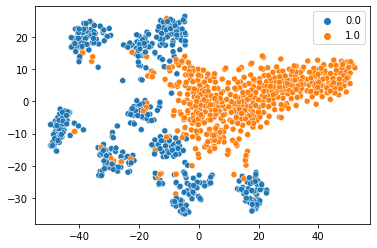

In [15]:
visualize_domain_tSNE(features, labels,size=1000)